## Creating random validation set from training images

In [1]:
import glob
import numpy as np
from shutil import move
from shutil import copyfile

In [140]:
%ls | wc -l #number of files in the directory

942


In [152]:
%cd /home/Akhil-Online/fastai/courses/dl1

/home/Akhil-Online/fastai/courses/dl1


In [43]:
g=glob.glob('*.jpg')
shuf=np.random.permutation(g)
for i in range(2000):move('/home/Akhil-Online/data/redux/train/'+shuf[i],'/home/Akhil-Online/data/redux/valid/'+shuf[i])

## Deep learning part

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
PATH = "data/redux/"

In [6]:
sz=224

In [157]:
!ls {PATH}

sample_submission.csv  test  test.zip  train  train.zip  valid


In [158]:
!ls {PATH}valid

cats  dogs


In [160]:
files = !ls {PATH}valid/cats | head
files

['cat.10010.jpg',
 'cat.10013.jpg',
 'cat.1001.jpg',
 'cat.10030.jpg',
 'cat.10048.jpg',
 'cat.1005.jpg',
 'cat.10062.jpg',
 'cat.10068.jpg',
 'cat.10075.jpg',
 'cat.10092.jpg']

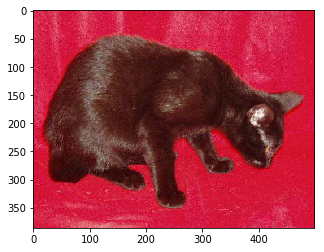

In [161]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [162]:
img.shape

(386, 499, 3)

In [164]:
img[:4,:4]

array([[[221,  51,  87],
        [227,  57,  93],
        [218,  48,  84],
        [208,  38,  74]],

       [[220,  50,  86],
        [224,  54,  90],
        [214,  44,  80],
        [206,  36,  72]],

       [[219,  49,  85],
        [221,  51,  87],
        [210,  40,  76],
        [204,  34,  70]],

       [[218,  48,  84],
        [218,  48,  84],
        [207,  37,  73],
        [204,  34,  70]]], dtype=uint8)

In [7]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.04703  0.02615  0.99023]                         



In [10]:
learn.fit(0.01, 10,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

[ 0.       0.03445  0.02461  0.98877]                         
[ 1.       0.03238  0.02238  0.99121]                         
[ 2.       0.03198  0.02398  0.98926]                         
[ 3.       0.02732  0.02618  0.98926]                         
[ 4.       0.02747  0.02689  0.98975]                         
[ 5.       0.02824  0.02339  0.98877]                         
[ 6.       0.02735  0.02622  0.98975]                         
[ 7.       0.02271  0.02652  0.98926]                         
[ 8.       0.02028  0.02499  0.98877]                         
[ 9.       0.02404  0.03013  0.98926]                         



In [166]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [167]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [168]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [169]:
log_preds[:10]

array([[ -0.00159,  -6.44386],
       [ -0.00024,  -8.33911],
       [ -0.00003, -10.3286 ],
       [ -0.01502,  -4.20571],
       [ -0.011  ,  -4.51571],
       [ -0.0002 ,  -8.53374],
       [ -0.00002, -11.01227],
       [ -0.03033,  -3.51066],
       [ -0.00005, -10.00511],
       [ -0.00006,  -9.70765]], dtype=float32)

In [170]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [171]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [172]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [173]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [174]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


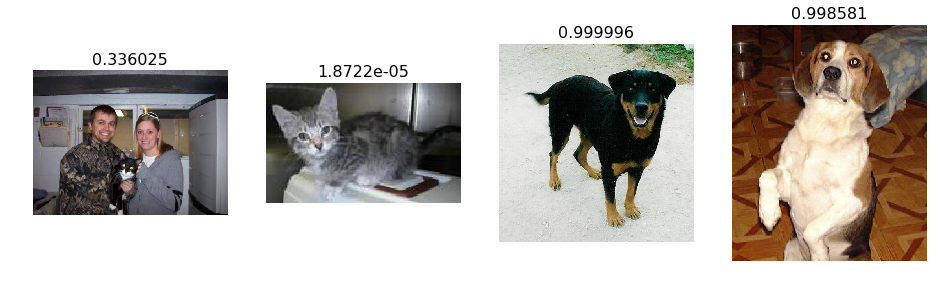

In [175]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


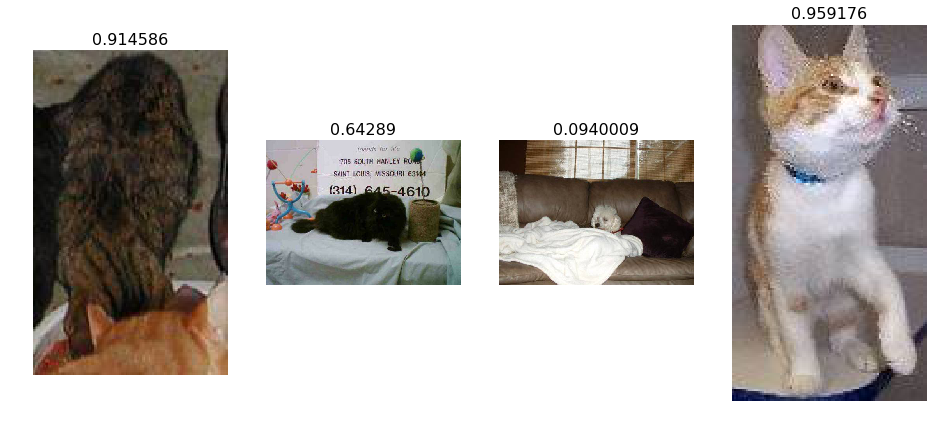

In [176]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [177]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most correct cats


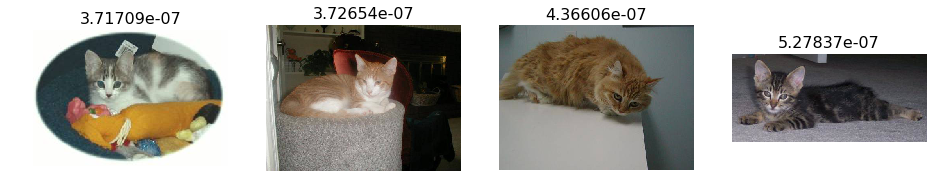

In [178]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


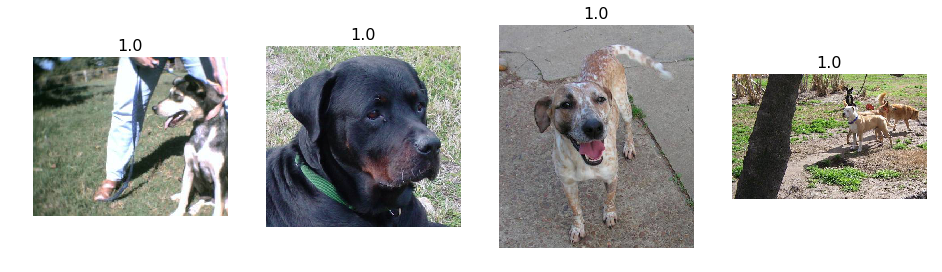

In [179]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


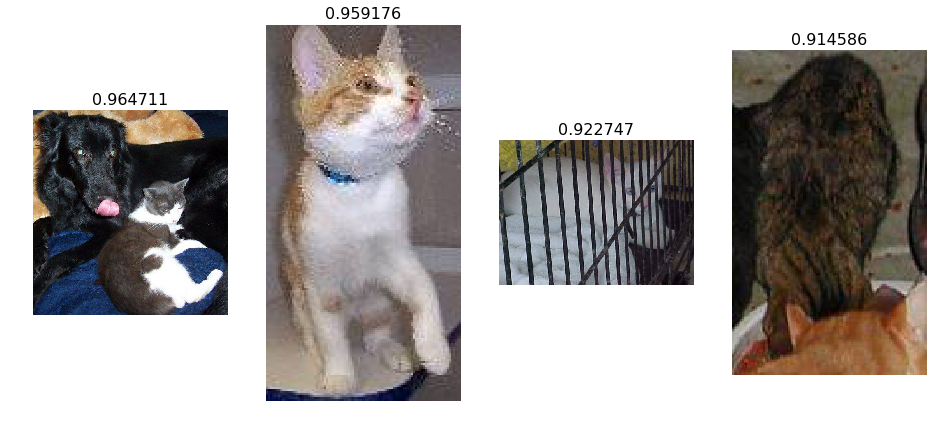

In [180]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


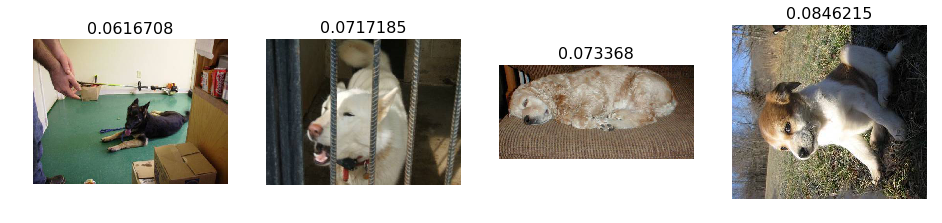

In [181]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


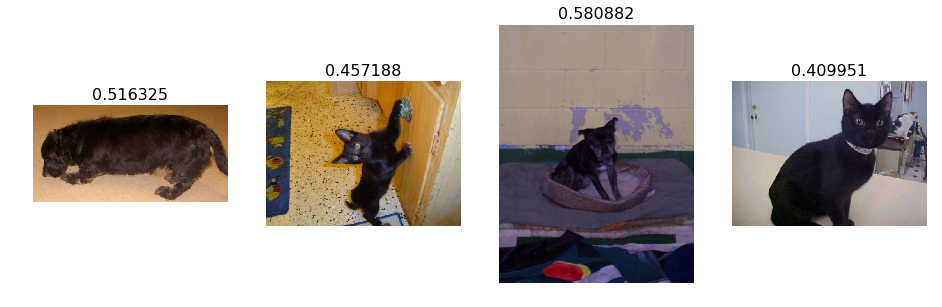

In [182]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [185]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [186]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▌ | 307/360 [00:04<00:00, 62.93it/s, loss=0.396] 


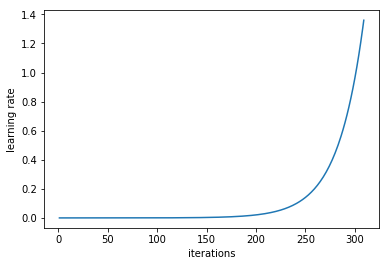

In [187]:
learn.sched.plot_lr()

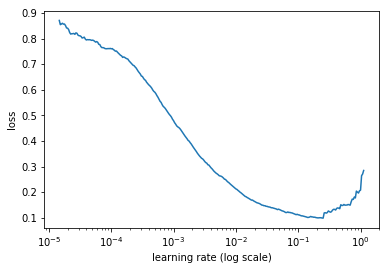

In [188]:
learn.sched.plot()

In [1]:
from fastai.conv_learner import *

In [5]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [6]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [7]:
ims = np.stack([get_augs() for i in range(6)])

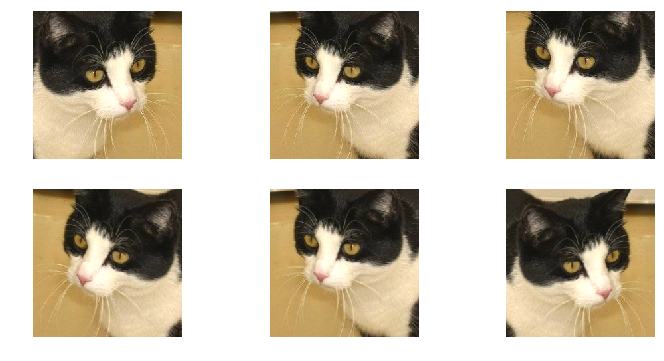

In [12]:
plots(ims, rows=2)

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)


In [194]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.05484  0.02199  0.9917 ]                         



In [11]:
learn.precompute=False

In [12]:
learn.fit(1e-2, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.02224  0.02614  0.99023]                         



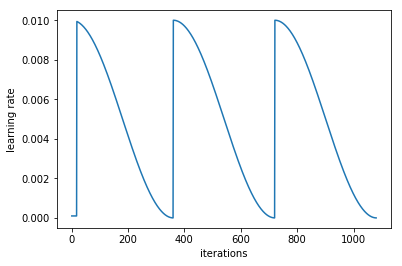

In [197]:
learn.sched.plot_lr()

In [199]:
learn.save('224_lastlayer')

In [8]:
learn.load('224_lastlayer')

RuntimeError: While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([1024]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).

In [201]:
learn.unfreeze()

In [202]:
lr=np.array([1e-4,1e-3,1e-2])

In [203]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.05283  0.02136  0.99268]                         
[ 1.       0.04051  0.01803  0.99414]                         
[ 2.       0.03086  0.01846  0.99219]                         
[ 3.       0.02768  0.01779  0.99365]                         
[ 4.       0.02502  0.01638  0.99414]                         
[ 5.       0.01833  0.01466  0.99512]                         
[ 6.       0.01851  0.01487  0.99463]                         



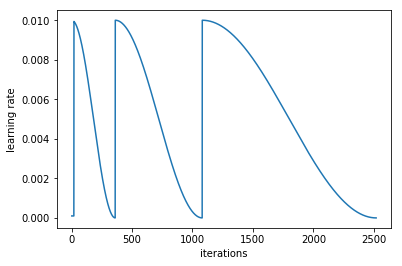

In [204]:
learn.sched.plot_lr()

In [205]:
learn.save('224_all')

In [16]:
learn.load('224_all')

RuntimeError: While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([1024]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).

In [207]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [208]:
accuracy(probs, y)

0.99450000000000005

In [209]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [210]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[1054    4]
 [   7  935]]


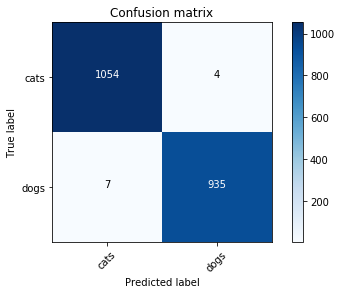

In [211]:
plot_confusion_matrix(cm, data.classes)


Most incorrect cats


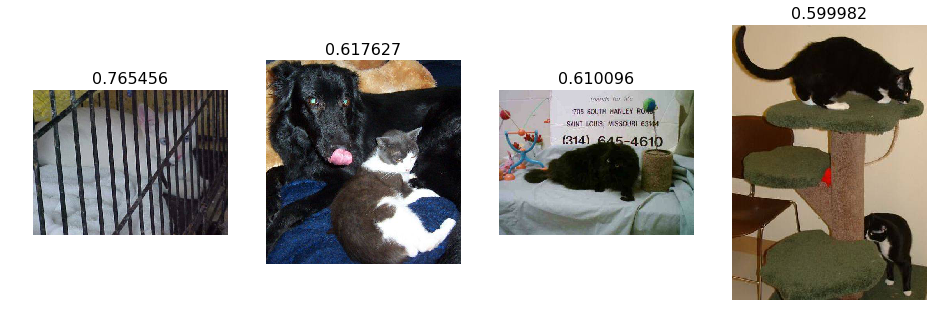

In [212]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


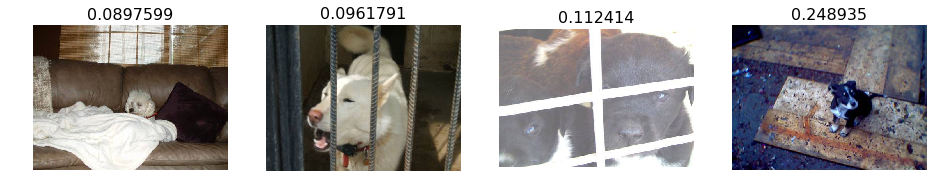

In [213]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")